# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [8]:
import numpy as np

X_train, y_train = train['X'], train['y']
X_test, y_test = test['X'], test['y']

X_train = np.transpose(X_train, (3, 0, 1, 2))
X_test = np.transpose(X_test, (3, 0, 1, 2))

y_train = y_train.flatten()
y_test = y_test.flatten()

y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

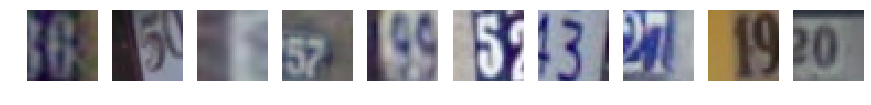

In [10]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(1,10, figsize=(15,3))

import random 
random_index = random.sample(range(X_train.shape[0]), 10)

for i , index in enumerate(random_index):
    axes[i].imshow(X_train[index])
    axes[i].axis('off')
plt.show()

In [28]:
X_train_grey = np.mean(X_train, axis=-1, keepdims=True)
X_test_grey = np.mean(X_test, axis=-1, keepdims=True)

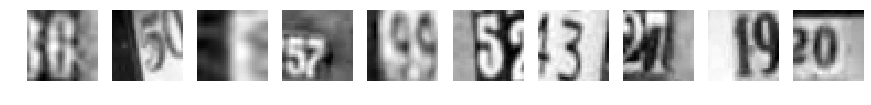

In [29]:
fig, axes = plt.subplots(1,10, figsize=(15,3))
for i , index in enumerate(random_index):
    axes[i].imshow(X_train_grey[index].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [30]:
from tensorflow.keras.utils import to_categorical

X_train_grey = X_train_grey / 255.0
X_test_grey = X_test_grey/ 255.0

y_train_oh = to_categorical(y_train, num_classes=10)
y_test_oh = to_categorical(y_test, num_classes=10)

In [31]:
from sklearn.model_selection import train_test_split

X_train_grey , X_val_grey, y_train_oh, y_val_oh = train_test_split(X_train_grey, y_train_oh, test_size=0.2, random_state=42)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

mlp = Sequential([
    Flatten(input_shape=(32,32,1)),
    Dense(256, activation= 'relu'),
    Dense(128, activation= 'relu'),
    Dense(64, activation= 'relu'),
    Dense(32, activation= 'relu'),
    Dense(10, activation= 'softmax')
])
mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 305,962
Trainable params: 305,962
Non-trainable params: 0
________________________________________________

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks=[
    EarlyStopping(patience=2, restore_best_weights=True),
    ModelCheckpoint('mlp_best_model.h5', save_best_only=True)
]

history = mlp.fit(
    X_train_grey, y_train_oh, validation_data=(X_val_grey, y_val_oh),
    epochs=30,
    batch_size=128,
    callbacks= callbacks
)

Train on 58605 samples, validate on 14652 samples
Epoch 1/30
58605/58605 [==============================] - 21s 350us/sample - loss: 0.8323 - accuracy: 0.7415 - val_loss: 0.8635 - val_accuracy: 0.7339
Epoch 2/30
58605/58605 [==============================] - 19s 328us/sample - loss: 0.7963 - accuracy: 0.7521 - val_loss: 0.8086 - val_accuracy: 0.7499
Epoch 3/30
58605/58605 [==============================] - 19s 326us/sample - loss: 0.7821 - accuracy: 0.7559 - val_loss: 0.8022 - val_accuracy: 0.7507
Epoch 4/30
58605/58605 [==============================] - 19s 326us/sample - loss: 0.7642 - accuracy: 0.7628 - val_loss: 0.7948 - val_accuracy: 0.7561
Epoch 5/30
58605/58605 [==============================] - 19s 331us/sample - loss: 0.7331 - accuracy: 0.7715 - val_loss: 0.7836 - val_accuracy: 0.7557
Epoch 6/30
58605/58605 [==============================] - 19s 325us/sample - loss: 0.7305 - accuracy: 0.7709 - val_loss: 0.7305 - val_accuracy: 0.7779
Epoch 7/30
58605/58605 [====================

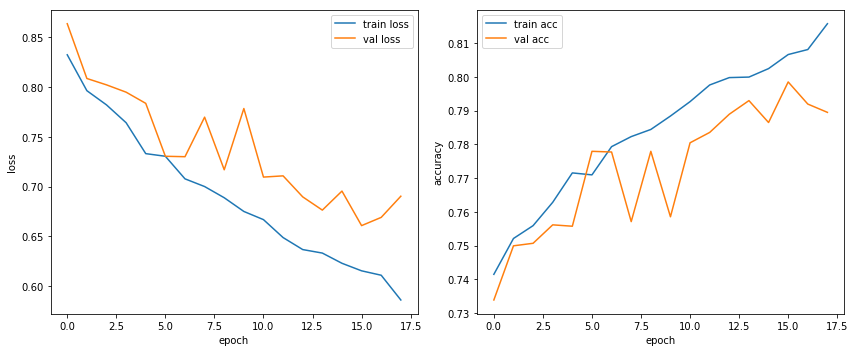

In [39]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
test_loss, test_acc = mlp.evaluate(X_test_grey, y_test_oh)
print(f"tess_loss : {test_loss} and test_acc : {test_acc}")

26032/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

tess_loss : 0.7656282422618772 and test_acc : 0.7754302620887756


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [46]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout

cnn_model = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(32,32,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)             

In [58]:
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cnn_callbacks = [
    EarlyStopping(patience=2, restore_best_weights=True),
    ModelCheckpoint('cnn_best_model.h5', save_best_only=True)
]

In [69]:
subset_size = 30000
indices = np.random.choice(len(X_train_grey), subset_size, replace=False)

X_train_small = X_train_grey[indices]
y_train_small = y_train_oh[indices]

cnn_model.fit(
    X_train_small, y_train_small,
    batch_size=256,
    epochs=10,
    validation_data=(X_val_grey / 255., y_val_oh),
    callbacks=cnn_callbacks
)

Train on 30000 samples, validate on 14652 samples
Epoch 1/10
30000/30000 [==============================] - 154s 5ms/sample - loss: 0.7440 - accuracy: 0.7718 - val_loss: 3.9456 - val_accuracy: 0.0943
Epoch 2/10
30000/30000 [==============================] - 152s 5ms/sample - loss: 0.5656 - accuracy: 0.8297 - val_loss: 6.6980 - val_accuracy: 0.1942
Epoch 3/10
30000/30000 [==============================] - 151s 5ms/sample - loss: 0.4880 - accuracy: 0.8508 - val_loss: 3.3892 - val_accuracy: 0.1944
Epoch 4/10
30000/30000 [==============================] - 153s 5ms/sample - loss: 0.4564 - accuracy: 0.8557 - val_loss: 5.4561 - val_accuracy: 0.1942
Epoch 5/10
30000/30000 [==============================] - 150s 5ms/sample - loss: 0.4221 - accuracy: 0.8677 - val_loss: 3.2905 - val_accuracy: 0.0658
Epoch 6/10
30000/30000 [==============================] - 148s 5ms/sample - loss: 0.3943 - accuracy: 0.8750 - val_loss: 4.1798 - val_accuracy: 0.1942
Epoch 7/10
30000/30000 [==========================

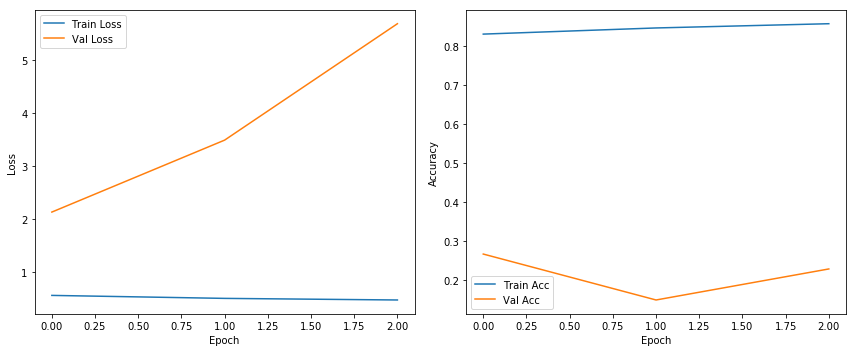

In [72]:
plt.figure(figsize=(12, 5))
history = cnn_model

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Acc')
plt.plot(cnn_history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test_grey, y_test_oh)
print(f"test acc: {test_acc_cnn:.4f}, test loss: {test_loss_cnn:.4f}")

26032/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test acc: 0.8571, test loss: 0.5171


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

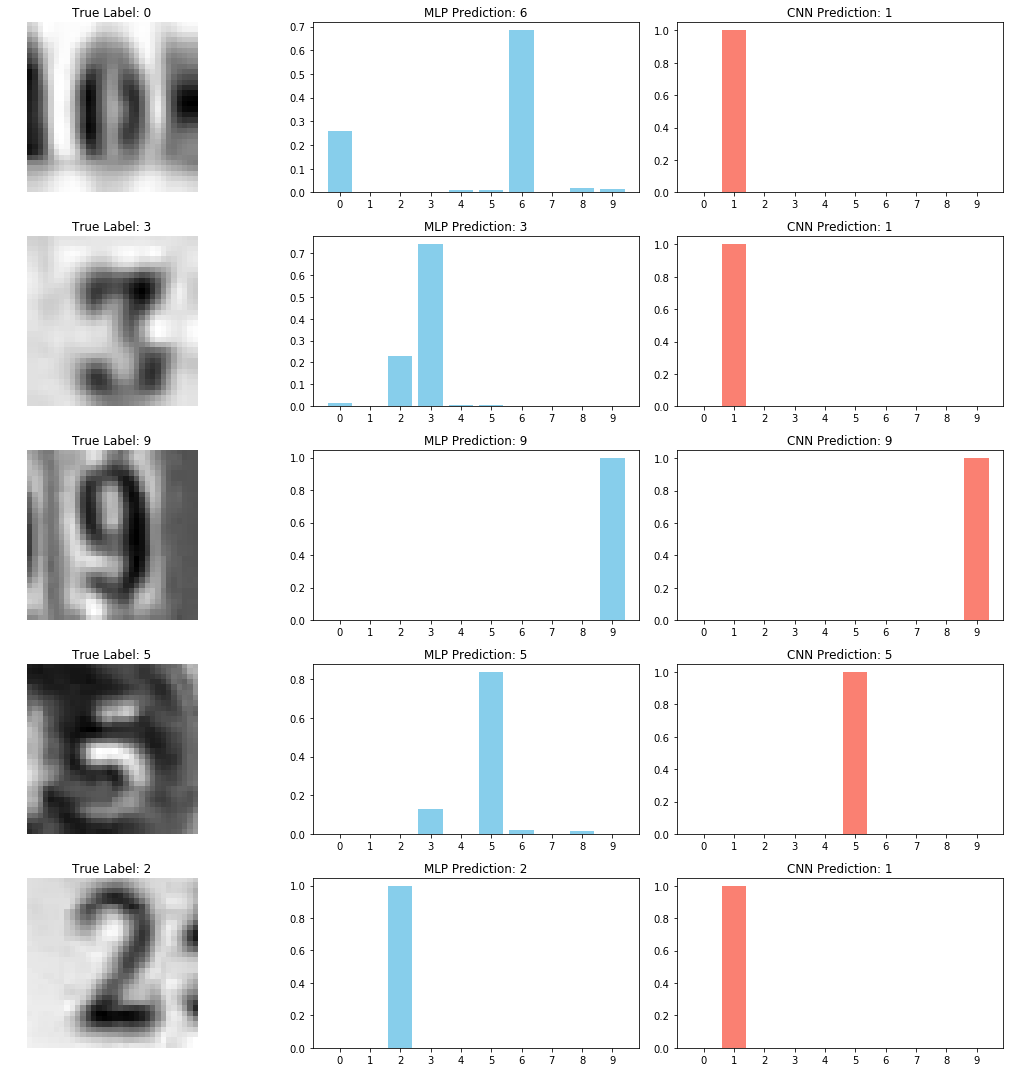

In [73]:
from tensorflow.keras.models import load_model

mlp.load_weights('mlp_best_model.h5')
cnn_model.load_weights('cnn_best_model.h5')

random_indices = np.random.choice(len(X_test_grey), size=5, replace=False)
plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    img = X_test_grey[idx]
    label = np.argmax(y_test_oh[idx])

    mlp_pred = mlp.predict(img.reshape(1, 32, 32, 1))[0]
    cnn_pred = cnn_model.predict(img.reshape(1, 32, 32, 1))[0]

    mlp_label = np.argmax(mlp_pred)
    cnn_label = np.argmax(cnn_pred)

    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"True Label: {label}")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.bar(range(10), mlp_pred, color='skyblue')
    plt.title(f"MLP Prediction: {mlp_label}")
    plt.xticks(range(10))

    plt.subplot(5, 3, i * 3 + 3)
    plt.bar(range(10), cnn_pred, color='salmon')
    plt.title(f"CNN Prediction: {cnn_label}")
    plt.xticks(range(10))

plt.tight_layout()
plt.show()
